# Clustering 1 - Sequential clustering

## Introduction

- Often important to find groups in data.
- Vastly important in data processing.

## Example

- Clustering in modern computer vision
- [**DINOv2: Learning Robust Visual Features without Supervision**](https://arxiv.org/pdf/2304.07193)

<p float="left">
    <img src="media/dino_cluster.png" width="600" />
</p>

## Clustering: Science or Art?

- [**Is there such a thing as a "correct" clustering?**](https://proceedings.mlr.press/v27/luxburg12a/luxburg12a.pdf)

<p float="left">
    <img src="media/thesis.png" width="200" />
    <img src="media/cluster_results.png" width="400" />
    <img src="media/explanation.png" width="400" />
</p>

### Key points

- Often no prior knowledge about data -> unsupervised
- Different ways of specifying groups / clusters -> different answers.

### Loose idea of clustering

- Find natural groups such that:
    - Points in the same cluster "similar".
    - Points in different clusters are "dissimilar".
- Draw example:

### Different types of clustering

- Will look at:
    - Sequential
    - Hierarchical
    - Function optimization
        - K-means
        - Spectral
    - Clustering evaluation

## Membership functions

- Let $$X = \{\mathbf{x_1}, \cdots, \mathbf{x_N}\}$$
- Task: Assign cluster memberships to $\mathbf{x}_i$ for $i=1,\cdots,N$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
centers = np.array([[0.0, 0.0],
                    [5.0, 0.0],
                    [2.5, 4.0]])
points_per_cluster = 4

X = []
labels = []
for k, c in enumerate(centers):
    pts = c + 0.3 * rng.normal(size=(points_per_cluster, 2))
    X.append(pts)
    labels += [k] * points_per_cluster

X = np.vstack(X)
labels = np.array(labels)

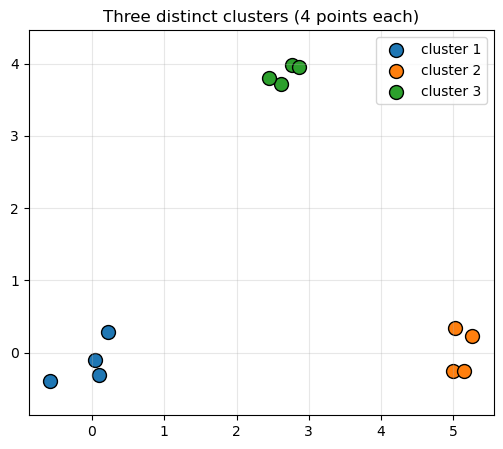

In [4]:
plt.figure(figsize=(6, 5))
for k in range(3):
    ix = labels == k
    plt.scatter(X[ix, 0], X[ix, 1], s=100, label=f'cluster {k+1}', edgecolor='k')
plt.title('Three distinct clusters (4 points each)')
plt.legend()
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()

### Membership functions

- Assume $m$ clusters.
- Let $u_j: \mathbf{x} \rightarrow \{0, 1\}$.
- Subject to: $\sum_{j=1}^{^m} u_j (\mathbf{x}_i)=1$ for $i=1,\cdots,N$

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
centers = np.array([[0.0, 0.0],
                    [5.0, 0.0],
                    [2.5, 4.0]])
points_per_cluster = 4

X = []
labels = []
for k, c in enumerate(centers):
    pts = c + 0.3 * rng.normal(size=(points_per_cluster, 2))
    X.append(pts)
    labels += [k] * points_per_cluster

# Add two points in-between the clusters (bridge/intermediate points)
bridge_pts = np.array([
    [2.5, 0.0],  # between left and right clusters
    [2.5, 2.0],  # between base and top cluster
])
X.append(bridge_pts)
labels += [3, 3]  # assign a separate id for these bridge points

X = np.vstack(X)
labels = np.array(labels)


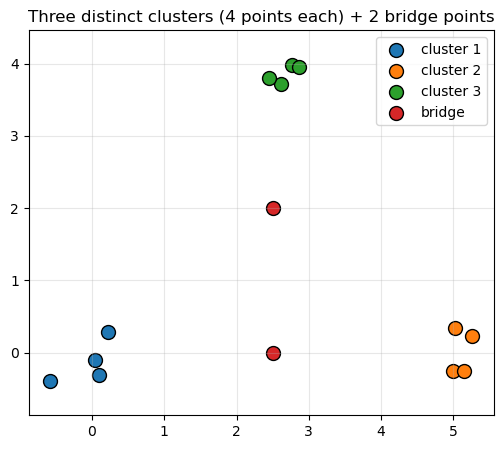

In [6]:
plt.figure(figsize=(6, 5))
for k in np.unique(labels):
    ix = labels == k
    lbl = f'cluster {k+1}' if k < 3 else 'bridge'
    plt.scatter(X[ix, 0], X[ix, 1], s=100, label=lbl, edgecolor='k')
plt.title('Three distinct clusters (4 points each) + 2 bridge points')
plt.legend()
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()

### Fuzzy membership

- Let $u_j: \mathbf{x} \rightarrow [0, 1]$.
- Subject to: $\sum_{j=1}^{^m} u_j (\mathbf{x}_i)=1$ for $i=1,\cdots,N$
- Going from discrete to continious assignments
    - Opens the door for derivative-based optimization.

## Proximity measures

- Both dissimilarity and similarity
    - Between pairs of vectors
    - Between vector and set
    - Between pairs of sets

### Proximity measures between pairs of vectors

- Let d : X × X → ℝ be a dissimilarity (distance) between vectors.

1. Non‑negativity  
   d(x, y) ≥ d_0 for all x, y.

2. Identity  
   d(x, x) = d_0 for all x.  

3. Symmetry  
   d(x, y) = d(y, x) for all x, y.

4. Triangle inequality  
   d(x, z) ≤ d(x, y) + d(y, z) for all x, y, z.

- A function satisfying 1–4 is a metric.
- Note: some useful proximity measures (similarities, asymmetric scores, etc.) violate one or more of these properties.
    - Divergence measures

### Examples for dissimilarity measure

- Weigthed $l_p$ metric dissimilarity measure: $d(\mathbf{x}, \mathbf{y}) = \big( \sum_{i=1}^{l} w_i|x_i-y_i|^p\big)^{1/p}$ for $\mathbf{x}, \mathbf{y} \in \mathbb{R}$.
- Euclidean distance:
    - $d_2(\mathbf{x}, \mathbf{y}) = \sqrt{{\sum_{i=1}^{l} (x_i-y_i)^2}}$
- Manhattan: 
    - $d_1(\mathbf{x}, \mathbf{y}) = {\sum_{i=1}^{l} |x_i-y_i|}$
- l-infinity:
    $d_\infty(\mathbf{x}, \mathbf{y}) = \text{max} |x_i-y_i|$ for $1\leq i \leq l$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# grid
xs = np.linspace(-1.5, 1.5, 401)
ys = np.linspace(-1.5, 1.5, 401)
X, Y = np.meshgrid(xs, ys)

# norms
L2 = np.sqrt(X**2 + Y**2)                # Euclidean
L1 = np.abs(X) + np.abs(Y)              # Manhattan
Linf = np.maximum(np.abs(X), np.abs(Y)) # L-infinity (Chebyshev)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


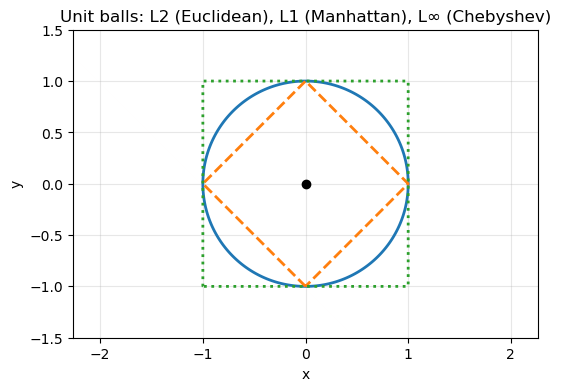

In [11]:
plt.figure(figsize=(6,4))
c1 = plt.contour(X, Y, L2,  levels=[1.0], colors='C0', linewidths=2, linestyles='-')
c2 = plt.contour(X, Y, L1,  levels=[1.0], colors='C1', linewidths=2, linestyles='--')
c3 = plt.contour(X, Y, Linf, levels=[1.0], colors='C2', linewidths=2, linestyles=':')
plt.scatter(0, 0, color='k', zorder=5)
plt.axis('equal')
plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Unit balls: L2 (Euclidean), L1 (Manhattan), L\u221E (Chebyshev)')
plt.grid(alpha=0.3)
plt.show()

### Examples of similarity measures

- Inner-product: $$ s_i(\mathbf{x},\mathbf{y}) = \mathbf{x}^T \mathbf{y}$$
- Cosine: $$ s_i(\mathbf{x},\mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{||\mathbf{x}|| ||\mathbf{y}||} $$
- From dissimilarity measure: $s = \frac{a}{d}$ or $s = d_{\text{max}}-d$

## Between vector and set C

- Max proximity: $$\rho_{\text{max}}(\mathbf{x}, C) = \underset{ \mathbf{y} \in C}{\max}\; \rho(\mathbf{x}, \mathbf{y})$$
- Min proximity: $$\rho_{\text{min}}(\mathbf{x}, C) = \underset{ \mathbf{y} \in C}{\min}\; \rho(\mathbf{x}, \mathbf{y})$$
- Average proximity: $$\rho_{\text{avg}}(\mathbf{x}, C) = \frac{1}{n_c}\sum_{\mathbf{y} \in C} \rho(\mathbf{x}, \mathbf{y}) $$

- And similarliy for proximity between set $C_i$ and $C_j$


In [18]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
centers = np.array([[0.0, 0.0],
                    [5.0, 0.0],
                    [2.5, 4.0]])
points_per_cluster = 4

X = []
labels = []
for k, c in enumerate(centers):
    pts = c + 0.3 * rng.normal(size=(points_per_cluster, 2))
    X.append(pts)
    labels += [k] * points_per_cluster

# Add two points in-between the clusters (bridge/intermediate points)
bridge_pts = np.array([
    [2.5, 0.0],  # between left and right clusters
    [2.5, 2.0],  # between base and top cluster
])
X.append(bridge_pts)
labels += [3, 3]  # assign a separate id for these bridge points

X = np.vstack(X)
labels = np.array(labels)


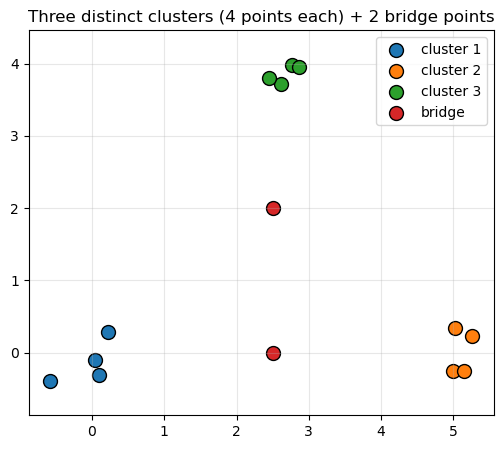

In [19]:
plt.figure(figsize=(6, 5))
for k in np.unique(labels):
    ix = labels == k
    lbl = f'cluster {k+1}' if k < 3 else 'bridge'
    plt.scatter(X[ix, 0], X[ix, 1], s=100, label=lbl, edgecolor='k')
plt.title('Three distinct clusters (4 points each) + 2 bridge points')
plt.legend()
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()

## Basic sequential algorithmic scheme (BSAS)

- Examine all samples in $X = \{\mathbf{x_1}, \cdots, \mathbf{x_N}\}$ sequentially.
- Pseduo-code:

### Remarks to BSAS

- Order important!
- Threshold important!
- Vectors are assigned to clusters before the number of clusters are determined.

## Modified Basic sequential algorithmic scheme (MBSAS)

- First; determine clusters.
- Second: pattern clssification.
- Requires two passes through the data.
- Pseduo-code:


## Programming exercises

Below are programming exercises assocaited with this lecture. These cell blocks are starting points that loads the data and prepares the problem such that you can get going with the implementation. There are also theoretical exercsies, but due to copyright we cannot shared them here. They will be made available in a private repository connected to the course.


### BSAS on simple 2-dimensional data

This first exercise is focused on simple 2-dimensional data such that you can familiarize yourself with the BSAS algorithm. Cluster the data stored in X using different thresholds and order, and observe how it affects the clustering.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

X = np.array([[1, 1], [1, 2], [2, 2],[2, 3], [3, 3], [3, 4], [4, 4], [4, 5],
              [5, 5], [5, 6], [-4, 5], [-3, 5], [-4, 4], [-3, 4]])

threshold = np.sqrt(2)


order_a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
order_b = [0, 9, 1, 2, 3, 10, 11, 4, 5, 6, 12, 7, 13, 8]
order_c = [0, 9, 4, 1, 2, 10, 11, 3, 5, 6, 12, 13, 7, 8]

### BSAS on the Iris dataset.

Use the BSAS algorithm to cluster the Iris dataset. Experiment with order and threshold to see how you can fit the known number of classes (3) best.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features.iloc[:, :2]
feature_1_name = 'sepal length (cm)'
feature_2_name = 'sepal width (cm)'
y = np.zeros(150)
y[50:100] = 1
y[100:150] = 2
y_names = np.unique(iris.data.targets)


plt.figure(1)
for class_i, class_name in enumerate(y_names):
    plt.scatter(X.iloc[np.where(y == class_i)[0], 0], X.iloc[np.where(y == class_i)[0], 1], label=class_name)
plt.xlabel(feature_1_name)
plt.ylabel(feature_2_name)
plt.legend()
plt.show()
